<a href="https://colab.research.google.com/github/egatchal/CA_Model/blob/main/CA_DATASET_MCDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [107]:
url = "https://raw.githubusercontent.com/egatchal/CA_Model/main/CA_data.csv"

In [108]:
df = pd.read_csv(url)

In [109]:
shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
X = shuffled.drop("output", axis=1).values.astype(float)
y = shuffled["output"].values.astype(float)

X = torch.tensor(X).float()
y = torch.tensor(y).long()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [110]:
# Training loop
def model_train(X_train, X_test, y_train, y_test, net, loss_fn, optimizer, n_epochs = 10, batch_size = 100, is_MCDO=False, samples=1):
  avg_accuracy = []
  test_accuracy = []
  losses = []
  for epoch in range(n_epochs):
    net.train()
    batch_loss = []
    batch_accuracy = []
    for i in range(0, X_train.shape[0]-batch_size):
      out = net(X_train[i:i+batch_size, :])
      loss = loss_fn(out, y_train[i:i+batch_size])

      prediction = torch.max(out, 1)[1]
      pred_y = prediction.data.numpy()
      target_y = y_train[i:i+batch_size].data.numpy()
      accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)

      batch_accuracy.append(accuracy)
      batch_loss.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch % 5 == 0:
      avg_accuracy.append(np.mean(batch_accuracy))
      test_accuracy.append(eval(X_test, y_test, net, is_MCDO, samples))

  return avg_accuracy, test_accuracy

def eval(X_test, y_test, net, is_MCDO=False, samples=1):
  with torch.no_grad():
    output = []
    if is_MCDO: # implementation of MCDO
      net.train()
      for i in range(samples):
        output.append(net(X_test))
      output = torch.tensor(np.mean(output, axis=0))
    else:
      net.eval()
      output = net(X_test)
    prediction = torch.max(output, 1)[1]
    pred_y = prediction.data.numpy()
    target_y = y_test.data.numpy()
    acc = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
  return acc

In [111]:
nn_no_dropout = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

nn_dropout = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.Dropout(.1),
    nn.ReLU(),
    nn.Linear(10, 2),
)

nn_MCDO = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.Dropout(.1),
    nn.ReLU(),
    nn.Linear(10, 2),
)

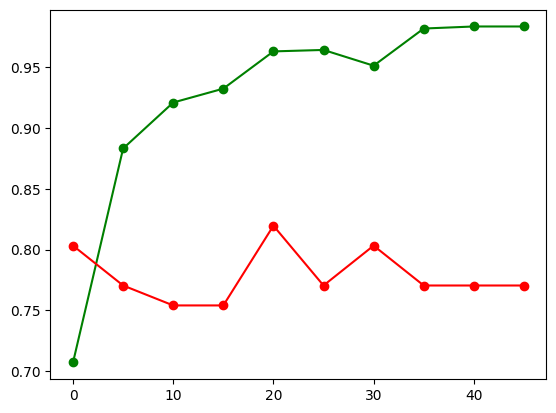

In [112]:
train_acc, test_acc = model_train(X_train, X_test, y_train, y_test, nn_no_dropout, nn.CrossEntropyLoss(), optim.Adam(nn_no_dropout.parameters(), lr=0.01), n_epochs=50)
plt.plot([i*5 for i in range(10)], train_acc, color='green', marker='o', label="Training")
plt.plot([i*5 for i in range(10)], test_acc, color='red', marker='o', label="Testing")

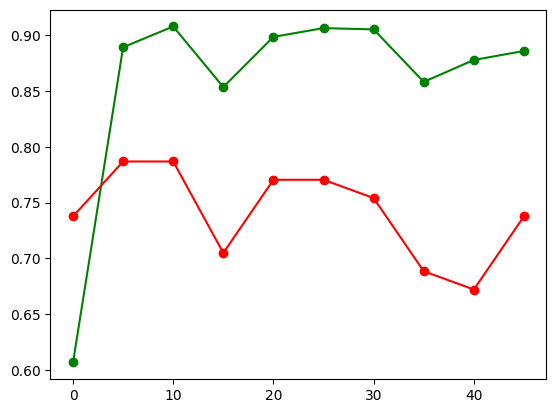

In [30]:
train_acc, test_acc = model_train(X_train, X_test, y_train, y_test, nn_dropout, nn.CrossEntropyLoss(), optim.Adam(nn_dropout.parameters(), lr=0.01), n_epochs=50)
plt.plot([i*5 for i in range(10)], train_acc, color='green', marker='o', label="Training")
plt.plot([i*5 for i in range(10)], test_acc, color='red', marker='o', label="Testing")

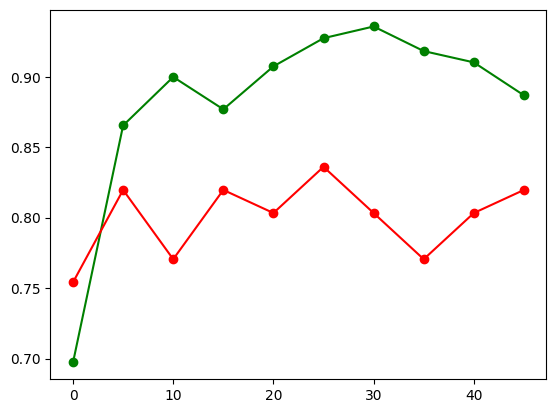

In [113]:
train_acc, test_acc = model_train(X_train, X_test, y_train, y_test, nn_MCDO, nn.CrossEntropyLoss(), optim.Adam(nn_MCDO.parameters(), lr=0.01), n_epochs=50, is_MCDO=True, samples=20)
plt.plot([i*5 for i in range(10)], train_acc, color='green', marker='o', label="Training")
plt.plot([i*5 for i in range(10)], test_acc, color='red', marker='o', label="Testing")

I implemented Monte Carlo Dropout using numpy and pytorch. Monte Carlo Dropout is a technique similar to regular Dropout where you drop a certain amount of neurons within a given layer during training. However, Monte Carlo Dropout drops neurons during training and testing, unlike regular Dropout. With this technique, your final prediction would be an average of the number of samples using the final model. Due to time constraints, I could not print out the models' multiple predictions given a specific feature value. By providing a graph, I could provide details of what the uncertainty would look like. For example, predictions around, say, ages 50-60 may be more susceptible to heart disease, leading to tighter predictions around that age since the data indicates that age is positively correlated with cardiac arrest. For other ages, you would see less certainty due to a lack of cases among those ages.